# 🧪 Optimization-Toolkit [(Github)](https://github.com/haven-ai/optimization-toolkit)

Use this Colab to develop and compare optimizers and models across a variety of datasets.

It contains optimizers like [Adam](https://https://arxiv.org/pdf/1412.6980.pdf), [SLS](https://arxiv.org/abs/1905.09997), [AdaSLS](https://arxiv.org/abs/2006.06835), [SPS](https://arxiv.org/pdf/2002.10542.pdf) and [LBFGS](https://www.cs.ubc.ca/~schmidtm/Software/minFunc.html) that could be ran on standard datastets like MNIST.

Run your first set of experiments with these 4 steps,

0. 🥕 **Install and Import Required Libraries**

1. 🤓 **Create Datasets, Models, and Optimizers**

2. 🎨 **Define list of experiments**

3. 🧠 **Train and Validate**

4. 📊 **Visualize the results**


You can run and visualize other large-scale experiments from this [Github Repo](https://github.com/haven-ai/optimization-toolkit). Original [Colab link](https://colab.research.google.com/drive/11rFC_5nnOTb3UBztg0S5F11QyRrq483d?usp=sharing#scrollTo=pEq-Mzmka1gU&uniqifier=1).


## 🌐 Credits 

Authors: 
- Issam H. Laradji <issam.laradji@gmail.com>
- Sharan Vaswani <vaswani.sharan@gmail.com>
- Kevin Murphy <kpmurphy@google.com>

License: 
- Apache License 2.0


## 0. Install and import required libraries

In [1]:
# Import Libraries
try:
    import sls
except ModuleNotFoundError:
    %pip install -q git+https://github.com/IssamLaradji/sls.git
    import sls

try:
    import sps
except ModuleNotFoundError:
    %pip install -q git+https://github.com/IssamLaradji/sps.git
    import sps

try:
    import adasls
except ModuleNotFoundError:
    %pip install -q git+https://github.com/IssamLaradji/ada_sls.git
    import adasls

import pandas as pd
import os
import shutil
import copy
import pprint

try:
    import torch
except ModuleNotFoundError:
    %pip install torch
    import torch
import numpy as np

try:
    import torchvision
except ModuleNotFoundError:
    %pip install torchvision
    import torchvision
try:
    import tqdm.notebook as tqdm
except ModuleNotFoundError:
    %pip install tqdm
    import tqdm.notebook as tqdm
import sklearn

try:
    import haven
except ModuleNotFoundError:
    %pip install haven
    %pip install haven-ai
    import haven

from haven import haven_utils as hu
from haven import haven_results as hr
from haven.haven_utils import exp_utils

import torch.nn.functional as F


from sklearn import preprocessing
from sklearn.datasets import load_iris

from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

try:
    from google.colab import data_table
except ModuleNotFoundError:
    %pip install google-colab
    from google.colab import data_table

     |████████████████████████████████| 5.8 MB 12.4 MB/s 
     |████████████████████████████████| 251 kB 79.5 MB/s 
  Created wheel for haven: filename=haven-2.0.3-py3-none-any.whl size=12186 sha256=2d0b0e7ba58b5939ecc13ac98b0a422c2049b729e75f63f54fb8ab950b702ba9
  Stored in directory: /root/.cache/pip/wheels/4a/1f/e5/22426f9f21f48807575a7863a11941066699ad8e405f3f8620
  Created wheel for events: filename=Events-0.4-py3-none-any.whl size=6275 sha256=e9ffdfaab125824786f45ebc71bf2b5e136514ed4530265387bc5d7e1f4c657e
  Stored in directory: /root/.cache/pip/wheels/7c/b6/4b/59a8b92c2ad6bb5807a6bba36032f2a21fb57a4cf6772f9982
  Created wheel for netkit: filename=netkit-3.1.10-py3-none-any.whl size=9452 sha256=081cbce5c096b7577c49176e184c59f8e0f9415bcf41ab23201de112e83f03ac
  Stored in directory: /root/.cache/pip/wheels/22/bd/09/22dab0d39f8891d41c60678b5425a5b7a98bdc9113d4b1c69b
Successfully built haven events netkit
     |████████████████████████████████| 92 kB 1.0 MB/s 
     |█████████████████

## 1) 🤓 Create datasets, models, and optimizers

- Add your dataset in `get_dataset()`
- Add your model in `get_model()`
- Add your optimizer in `get_optimizer()`

In [2]:
# Define a set of datasets
# ------------------------
def get_dataset(dataset_dict, split):
    name = dataset_dict["name"]
    if name == "syn":
        X, y = hu.make_binary_linear(n=1000, d=49, margin=0.5, separable=dataset_dict["separable"])
        dataset = hu.get_split_torch_dataset(X, y, split)
        dataset.task = "binary_classification"
        dataset.n_output = 1

        return dataset

    if name == "iris":
        # X, y = sklearn.datasets.load_iris(return_X_y=True)
        X, y = load_iris(return_X_y=True)
        X = preprocessing.StandardScaler().fit_transform(X)
        dataset = hu.get_split_torch_dataset(X, y, split)
        dataset.task = "multi_classification"
        dataset.n_output = 3

        return dataset

    if name == "diabetes":
        X, y = sklearn.datasets.load_diabetes(return_X_y=True)
        y = y / y.max()
        X = preprocessing.StandardScaler().fit_transform(X)
        dataset = hu.get_split_torch_dataset(X, y.astype("float"), split)
        dataset.task = "regression"
        dataset.n_output = 1
        return dataset

    if name == "imdb":
        train = True if split == "train" else False
        test = True if split == "val" else False
        dataset = imdb_dataset(train=train, test=test)
        X = [d["text"] for d in dataset]
        y = [d["sentiment"] for d in dataset]

        dataset.task = "classification"
        dataset.n_output = 1
        return dataset

    if name == "fashion_mnist":
        train = True if split == "train" else False
        dataset = torchvision.datasets.FashionMNIST(
            "data/",
            train=train,
            download=True,
            transform=torchvision.transforms.Compose(
                [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))]
            ),
        )
        dataset.n_input = 784
        dataset.task = "multi_classification"
        dataset.n_output = 10
        return dataset

    if name == "mnist":
        train = True if split == "train" else False
        dataset = torchvision.datasets.MNIST(
            "data/",
            train=train,
            download=True,
            transform=torchvision.transforms.Compose(
                [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))]
            ),
        )
        dataset.n_input = 784
        dataset.task = "multi_classification"
        dataset.n_output = 10
        return dataset


# Define a set of optimizers
# --------------------------
def get_optimizer(opt_dict, model, train_set, batch_size):
    name = opt_dict["name"]
    if name == "adam":
        return torch.optim.Adam(model.parameters(), lr=opt_dict.get("lr", 1e-3))

    elif name == "adasls":
        return adasls.AdaSLS(
            model.parameters(),
            c=opt_dict.get("c", 0.5),
            n_batches_per_epoch=opt_dict.get("n_batches_per_epoch", len(train_set) / batch_size),
        )
    elif name == "sls":
        return sls.Sls(
            model.parameters(),
            c=opt_dict.get("c", 0.5),
            n_batches_per_epoch=opt_dict.get("n_batches_per_epoch", len(train_set) / batch_size),
        )
    elif name == "sps":
        return sps.Sps(model.parameters(), c=opt_dict.get("c", 0.5))

    elif name == "sgd":
        return torch.optim.Sgd(model.parameters(), lr=opt_dict.get("lr", 1e-3), momentum=opt_dict.get("momentum", 0.0))

    elif name == "lbfgs":
        return torch.optim.LBFGS(
            model.parameters(),
            #  tolerance_change=1.,
            #  tolerance_grad=1e-5,
            max_iter=1,
            max_eval=1,
            lr=opt_dict.get("lr", 1),
            line_search_fn="strong_wolfe",
        )


# Define a set of models
# ----------------------
def get_model(model_dict, dataset):
    name = model_dict["name"]
    if name == "mlp":
        return MLP(dataset, model_dict["layer_list"])


class MLP(nn.Module):
    def __init__(self, dataset, layer_list):
        super().__init__()
        self.task = dataset.task
        layer_list = [dataset.n_input] + layer_list + [dataset.n_output]

        layers = [nn.Flatten()]
        for i in range(len(layer_list) - 1):
            layers += [nn.Linear(layer_list[i], layer_list[i + 1])]

        self.layers = nn.Sequential(*layers)
        self.n_forwards = 0

    def forward(self, x):
        return self.layers(x)

    def compute_loss(self, X, y):
        # Compute the loss based on the task
        logits = self(X)

        if self.task == "binary_classification":
            func = nn.BCELoss()
            loss = func(logits.sigmoid().view(-1), y.float().view(-1))
        if self.task == "multi_classification":
            func = nn.CrossEntropyLoss()
            loss = func(logits.softmax(dim=1), y)

        if self.task == "regression":
            func = nn.MSELoss()
            loss = F.mse_loss(logits.view(-1), y.float().view(-1))

        # Add L2 loss
        w = 0.0
        for p in self.parameters():
            w += (p**2).sum()
        loss += 1e-4 * w

        return loss

    def compute_score(self, X, y):
        # Computes the score based on the task
        logits = self(X)

        if self.task == "binary_classification":
            y_hat = (logits.sigmoid().view(-1) > 0.5).long()
            return (y_hat == y.view(-1)).sum()

        if self.task == "multi_classification":
            y_hat = logits.softmax(dim=1).argmax(dim=1).long()
            return (y_hat == y).sum()

        if self.task == "regression":
            return F.mse_loss(logits.view(-1), y.float().view(-1))

    def compute_metrics(self, dataset):
        metric_list = []
        n = len(dataset)
        loader = DataLoader(dataset, batch_size=100, shuffle=False, drop_last=False)

        for batch in loader:
            # get batch
            Xi, yi = batch
            # compute loss & acc
            loss = self.compute_loss(Xi, yi)
            score = self.compute_score(Xi, yi)
            # aggregate scores
            metric_list += [{"loss": float(loss) / n, "score": float(score) / n}]
        metric_dict = pd.DataFrame(metric_list).sum().to_dict()

        return metric_dict

## 2) 🎨 Define list of experiments


In [3]:
# Specify the hyperparameters
# dataset_list = [{'name':'syn', 'separable':True, 'n_max':500}]
run_list = [0, 1]
# dataset_list = [{'name':'diabetes', 'n_max':-1}]
dataset_list = [{"name": "iris", "n_max": -1}]
# dataset_list = [{'name':'mnist', 'n_max':1000}]
model_list = [{"name": "mlp", "layer_list": []}]
opt_list = [
    {"name": "adasls", "c": 0.5, "batch_size": 128},
    {"name": "lbfgs", "lr": 1, "batch_size": -1},
    {"name": "adam", "lr": 1e-3, "batch_size": 128},
    # {'name':'adam', 'lr':1e-4, 'batch_size':128},
    {"name": "sps", "c": 0.5, "batch_size": 128},
    {"name": "sls", "c": 0.5, "batch_size": 128},
]

# Create experiments
exp_list = []
for dataset in dataset_list:
    for model in model_list:
        for opt in opt_list:
            for run in run_list:
                exp_list += [{"dataset": dataset, "model": model, "opt": opt, "epochs": 20, "run": run}]
print(f"Defined {len(exp_list)} experiments")

Defined 10 experiments


## 3) 🧠 Train and Validate

In [4]:
# Create main save directory
savedir_base = "results"
if os.path.exists(savedir_base):
    shutil.rmtree(savedir_base)


def trainval(exp_dict):
    # set seed
    seed = 5 + exp_dict["run"]
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # print exp dict
    savedir = f"{savedir_base}/{exp_utils.hash_dict(exp_dict)}"
    hu.save_json(os.path.join(savedir, "exp_dict.json"), exp_dict)

    # Get datasets
    train_set = get_dataset(exp_dict["dataset"], split="train")
    val_set = get_dataset(exp_dict["dataset"], split="val")

    # sample n_max examples
    n_max = exp_dict["dataset"]["n_max"]

    if n_max == -1 or n_max >= len(train_set):
        ind_list = np.arange(len(train_set))
        n_max = len(train_set)
    else:
        ind_list = np.random.choice(len(train_set), n_max, replace=False)

    train_set = torch.utils.data.Subset(train_set, ind_list)

    # choose full or mini-batch
    batch_size = exp_dict["opt"]["batch_size"]
    if batch_size < 0:
        batch_size = n_max
    batch_size = min(batch_size, len(train_set))

    print(
        f'Dataset: {exp_dict["dataset"]["name"]} ({len(train_set)}) '
        f'- Model: {exp_dict["model"]["name"]} - '
        f'Opt: {exp_dict["opt"]["name"]} ({batch_size})'
    )

    # get loader
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

    # Load model and optimizer
    model = get_model(exp_dict["model"], train_set.dataset)
    opt = get_optimizer(exp_dict["opt"], model, train_set.dataset, batch_size)

    score_list = []
    # start training and validating
    ebar = tqdm.tqdm(range(exp_dict["epochs"]), leave=False)

    model.n_calls = 0.0
    for e in ebar:
        # Compute Metrics on Validation and Training Set
        val_dict = model.compute_metrics(val_set)
        train_dict = model.compute_metrics(train_set)

        # Train a single epoch

        for batch in train_loader:
            # get batch
            Xi, yi = batch

            # define closure
            def closure():
                loss = model.compute_loss(Xi, yi)
                if exp_dict["opt"]["name"] not in ["adasls", "sls"]:
                    loss.backward()
                model.n_calls += Xi.shape[0]
                # print(Xi.shape[0])

                return loss

            # update parameters
            opt.zero_grad()
            loss = opt.step(closure=closure)

        # Update and save metrics
        score_dict = {}
        score_dict["epoch"] = e
        score_dict["val_score"] = val_dict["score"]
        score_dict["val_loss"] = val_dict["loss"]
        score_dict["train_loss"] = train_dict["loss"]
        score_dict["n_train"] = len(train_set)
        score_dict["step_size"] = opt.state.get("step_size", {})

        n_iters = len(train_loader) * (e + 1)
        score_dict["n_calls"] = int(model.n_calls)
        score_list += [score_dict]

        # Save metrics
        hu.save_pkl(os.path.join(savedir, "score_list.pkl"), score_list)
        ebar.update(1)
        ebar.set_description(f'Training Loss {train_dict["loss"]:.3f}')


# Run each experiment and save their results
pbar = tqdm.tqdm(exp_list)
for ei, exp_dict in enumerate(pbar):
    pbar.set_description(f"Running Exp {ei+1}/{len(exp_list)} ")
    trainval(exp_dict)

    # Update progress bar
    pbar.update(1)

  0%|          | 0/10 [00:00<?, ?it/s]

Dataset: iris (120) - Model: mlp - Opt: adasls (120)


  0%|          | 0/20 [00:00<?, ?it/s]

Dataset: iris (120) - Model: mlp - Opt: adasls (120)


  0%|          | 0/20 [00:00<?, ?it/s]

Dataset: iris (120) - Model: mlp - Opt: lbfgs (120)


  0%|          | 0/20 [00:00<?, ?it/s]

Dataset: iris (120) - Model: mlp - Opt: lbfgs (120)


  0%|          | 0/20 [00:00<?, ?it/s]

Dataset: iris (120) - Model: mlp - Opt: adam (120)


  0%|          | 0/20 [00:00<?, ?it/s]

Dataset: iris (120) - Model: mlp - Opt: adam (120)


  0%|          | 0/20 [00:00<?, ?it/s]

Dataset: iris (120) - Model: mlp - Opt: sps (120)


  0%|          | 0/20 [00:00<?, ?it/s]

Dataset: iris (120) - Model: mlp - Opt: sps (120)


  0%|          | 0/20 [00:00<?, ?it/s]

Dataset: iris (120) - Model: mlp - Opt: sls (120)


  0%|          | 0/20 [00:00<?, ?it/s]

Dataset: iris (120) - Model: mlp - Opt: sls (120)


  0%|          | 0/20 [00:00<?, ?it/s]

## 4) 📊 Visualize results

,started_at,dataset.name,model.layer_list,opt.name,epochs,opt.c,run,opt.lr,opt.batch_size,dataset.n_max,...,val_loss (max),val_loss (min),train_loss,train_loss (max),train_loss (min),n_train,step_size,step_size (max),step_size (min),n_calls
0,'12:42 AM (May 14)','iris',[],'adasls',20,0.5,0,NaN,128,-1,...,0.040735,0.024013,0.010375,0.020517,0.010375,120,0.8607036976050261,1.750704,0.437676,20760
1,'12:42 AM (May 14)','iris',[],'adasls',20,0.5,1,NaN,128,-1,...,0.047286,0.024109,0.010439,0.020078,0.010439,120,1.0625971575370692,3.660287,0.659683,20520
2,'12:42 AM (May 14)','iris',[],'lbfgs',20,NaN,0,1.000,-1,-1,...,0.040735,0.020601,0.009958,0.020517,0.009921,120,{},NaN,NaN,25440
3,'12:42 AM (May 14)','iris',[],'lbfgs',20,NaN,1,1.000,-1,-1,...,0.044225,0.022125,0.009956,0.020078,0.009948,120,{},NaN,NaN,22320
4,'12:42 AM (May 14)','iris',[],'adam',20,NaN,0,0.001,128,-1,...,0.040735,0.040308,0.020311,0.020517,0.020311,120,{},NaN,NaN,2400
5,'12:42 AM (May 14)','iris',[],'adam',20,NaN,1,0.001,128,-1,...,0.043015,0.042843,0.019834,0.020078,0.019834,120,{},NaN,NaN,2400
6,'12:42 AM (May 14)','iris',[],'sps',20,0.5,0,NaN,128,-1,...,0.040735,0.032180,0.013910,0.020517,0.013910,120,1.0281138266560677,1.028114,1.001387,2400
7,'12:42 AM (May 14)','iris',[],'sps',20,0.5,1,NaN,128,-1,...,0.043015,0.034864,0.014472,0.020078,0.014472,120,1.0281138266560677,1.028114,1.001387,2400
8,'12:42 AM (May 14)','iris',[],'sls',20,0.5,0,NaN,128,-1,...,0.040735,0.023524,0.010581,0.020517,0.010417,120,14.801506282995364,34.012224,2.000000,17520
9,'12:42 AM (May 14)','iris',[],'sls',20,0.5,1,NaN,128,-1,...,0.043015,0.023836,0.010636,0.020078,0.010452,120,20.30384949656428,32.000000,2.000000,17160


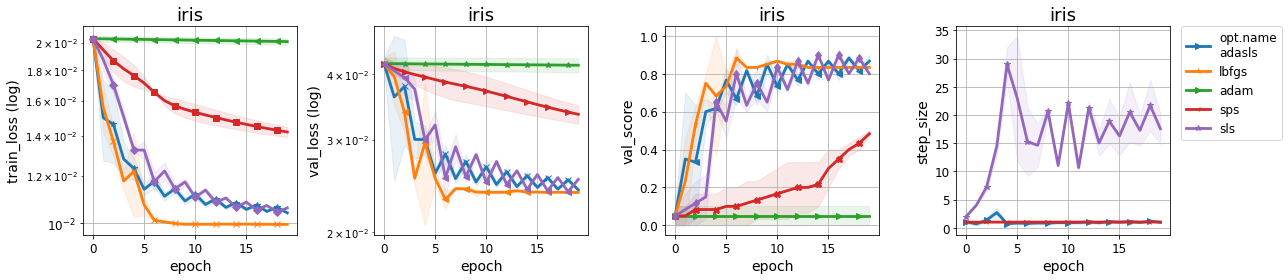

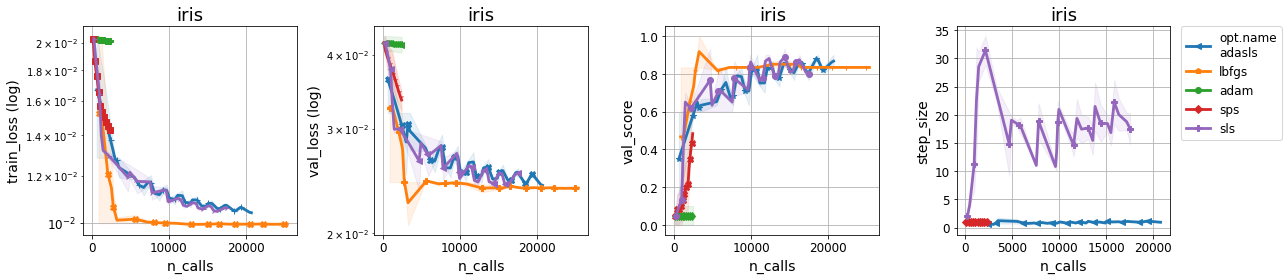

In [5]:
# Plot results
rm = hr.ResultManager(exp_list=exp_list, savedir_base=savedir_base, verbose=0)
rm.get_plot_all(
    y_metric_list=["train_loss", "val_loss", "val_score", "step_size"],
    x_metric="epoch",
    figsize=(18, 4),
    title_list=["dataset.name"],
    legend_list=["opt.name"],
    groupby_list=["dataset"],
    log_metric_list=["train_loss", "val_loss"],
    avg_across="run",
)

rm.get_plot_all(
    y_metric_list=["train_loss", "val_loss", "val_score", "step_size"],
    x_metric="n_calls",
    figsize=(18, 4),
    title_list=["dataset.name"],
    legend_list=["opt.name"],
    groupby_list=["dataset"],
    log_metric_list=["train_loss", "val_loss"],
    avg_across="run",
)

data_table.DataTable(rm.get_score_df(), include_index=False, num_rows_per_page=3)

## 🔨 Debug Section

In [ ]:
train_set = get_dataset({"name": "mnist"}, split="train")
len(train_set) / 128

468.75

In [ ]:
1000 / 128

7.8125

In [ ]:
7.8 * 20

156.0

In [ ]:
import pickle

p = {1: 2}
q = {3: 4}
filename = "picklefile"
with open(filename, "ab") as fp:
    pickle.dump(p, fp)
    pickle.dump(q, fp)

with open(filename, "rb") as fp:
    print(pickle.load(fp))
    print(pickle.load(fp))

{1: 2}
{3: 4}
